In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

from sklearn.datasets import load_breast_cancer
import shap
#plt.style.use('default')

shap.initjs()

Используем датасет <code>cancer</code> и случайный лес. Обучимся и посмотрим результат.

Важная особенность! Для простоты дальнейшей работы с библиотекой `SHAP` признаки `X` должны быть в виде `pd.DataFrame` с именами столбцов.

## 4. Интерпритация функции потерь (вызванная ощибкой в данных)

Объяснение сбоя в модели может быть очень полезным для отладки и мониторинга модели. 

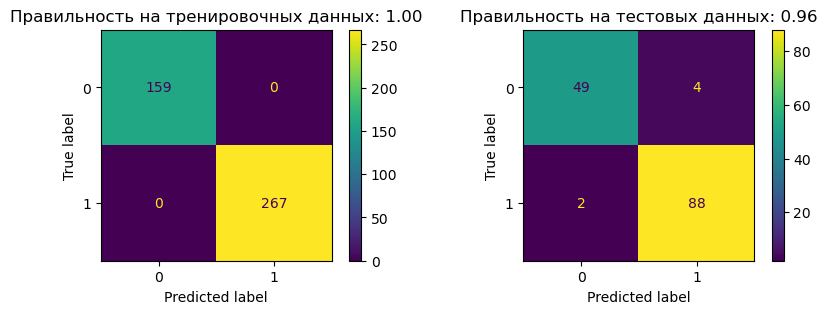

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

forest = RandomForestClassifier(n_estimators = 500, random_state = 42)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
y_train_pred = forest.predict(X_train)
y_pred_proba = forest.predict_proba(X_test)



fig, ax = plt.subplots(1,2, figsize=(10,3))
ConfusionMatrixDisplay.from_estimator(forest, X_train, y_train, ax = ax[0]);
ax[0].set_title( "Правильность на тренировочных данных: {:.2f}".format(forest.score(X_train, y_train)) )
ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, ax = ax[1]);
ax[1].set_title( "Правильность на тестовых данных: {:.2f}".format(forest.score(X_test, y_test)) );

In [3]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [4]:
explainer = shap.explainers.Tree(forest, X_train,  
                                 model_output="log_loss")
shap_values = explainer.shap_values(X_train.reset_index(drop = True),y_train)
shap_values_test = explainer.shap_values(pd.concat([X_train,X_test],ignore_index = True),y)

 94%|=================== | 1066/1138 [00:15<00:01]       

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


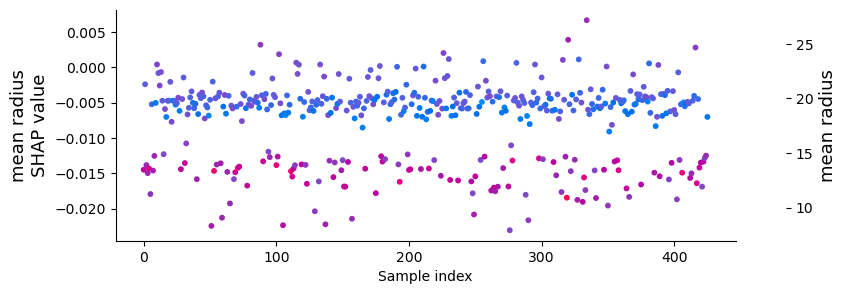

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


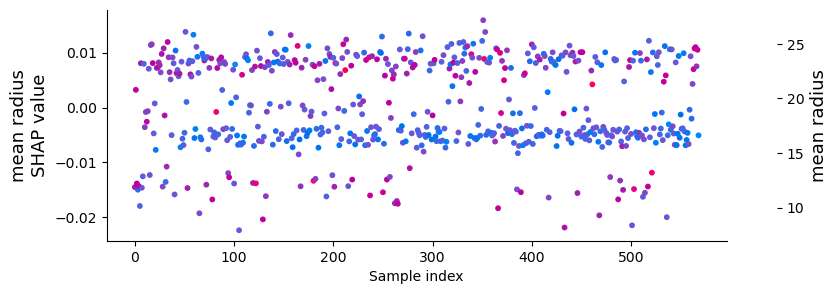

In [5]:
ind = X_train.columns.get_loc("mean radius")
shap.monitoring_plot(ind, shap_values[:,:,1], X_train)
shap.monitoring_plot(ind, shap_values_test[:,:,1], X)

In [6]:
Ser_A = X_test['mean radius']
Ser_B = X_test['mean texture']
X_test_nocorect = X_test
X_test_nocorect['mean radius']  = Ser_B
X_test_nocorect['mean texture'] = Ser_A

explainer = shap.TreeExplainer(forest, X_train, model_output="log_loss")
shap_values_test_bad = explainer.shap_values(pd.concat([X_train,X_test_nocorect],ignore_index = True),y)

100%|===================| 1136/1138 [00:16<00:00]        

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


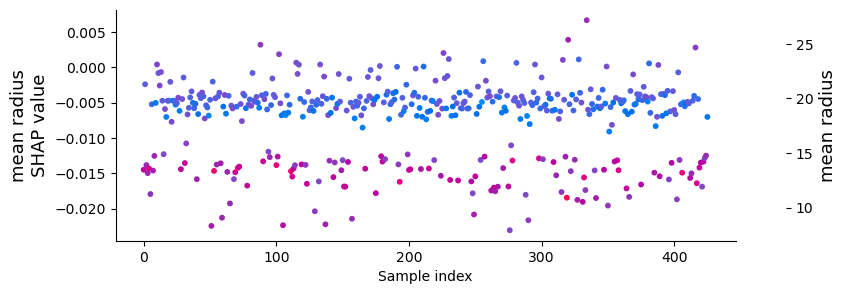

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


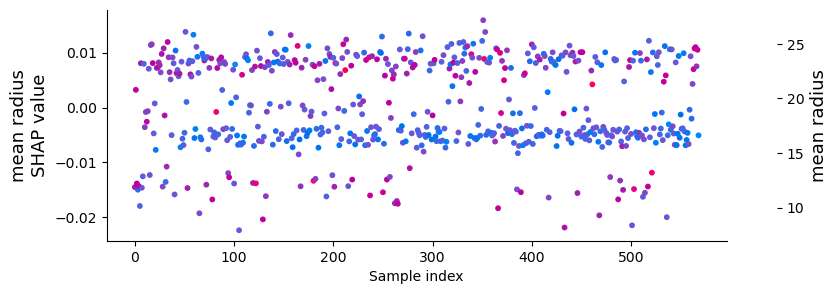

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


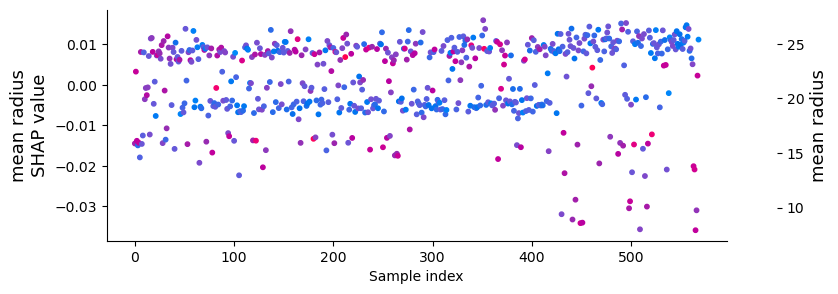

In [7]:
ind = X_train.columns.get_loc("mean radius")
shap.monitoring_plot(ind, shap_values[:,:,1], X_train)
shap.monitoring_plot(ind, shap_values_test[:,:,1], X)
shap.monitoring_plot(ind, shap_values_test_bad[:,:,1], X)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


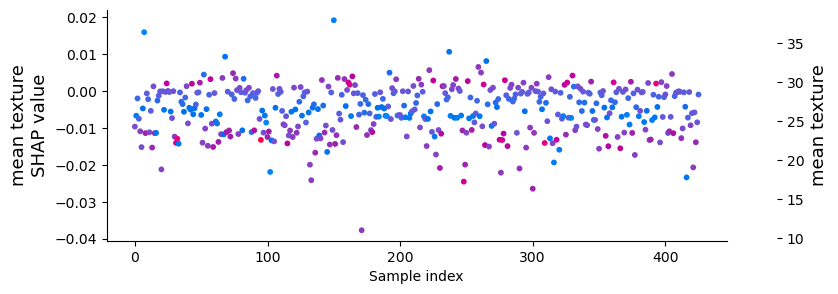

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


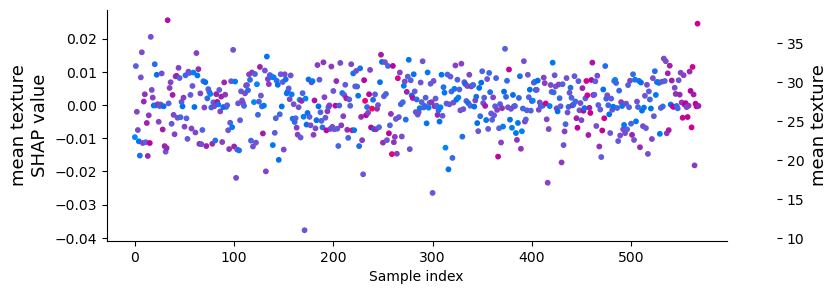

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


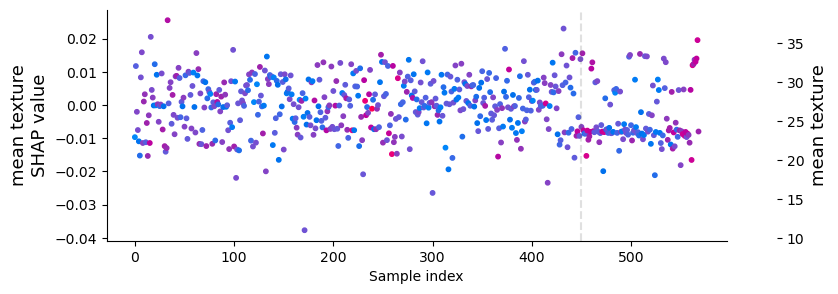

In [8]:
ind = X_train.columns.get_loc("mean texture")
shap.monitoring_plot(ind, shap_values[:,:,1], X_train)
shap.monitoring_plot(ind, shap_values_test[:,:,1], X)
shap.monitoring_plot(ind, shap_values_test_bad[:,:,1], X)

Почитать можно тут https://www.researchgate.net/figure/Monitoring-plots-reveal-problems-that-would-otherwise-be-invisible-in-a-retrospective_fig1_333077391
